<a href="https://colab.research.google.com/github/giedriusblazys/SDA_DS_class/blob/main/practice/decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Decision treas and Model explainability

In [1]:
# !pip install eli5
# !pip install pdpbox
# !pip install shop

**Data Source** https://www.kaggle.com/harlfoxem/housesalesprediction

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

**Column definitions** https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html
- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# improve how pandas numbers are displayed
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

In [4]:
# load the data set
df = pd.read_csv("https://github.com/giedriusblazys/SDA_DS_class/blob/main/practice/input/kc_house_data.csv?raw=true")
df.shape
# df = pd.read_csv("input/kc_house_data.csv")

(21613, 21)

In [5]:
type(df.date[0])

str

In [6]:
df.date = pd.to_datetime(df.date)
df['age'] = df.date.dt.year - df.yr_built

# aggregate zipcode level features

cols = ['floors', 'yr_built', 'view', 'condition', 'grade']
zip_cols = ['zip_' + x for x in cols]

df[zip_cols] = df.groupby('zipcode')[cols].transform('mean')

df['sql2'] = df.sqft_living * df.sqft_living

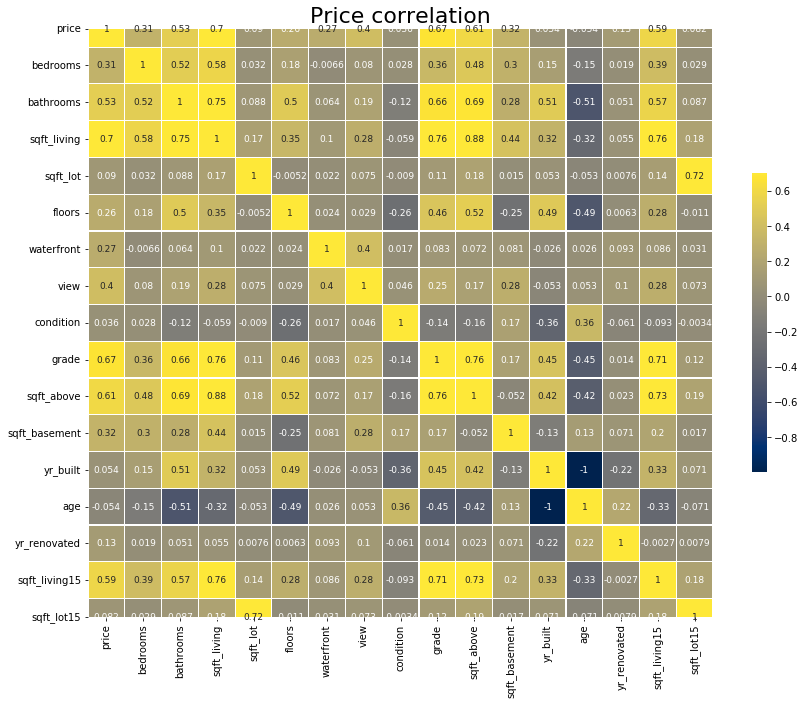

In [7]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
            'waterfront', 'view','condition','grade','sqft_above','sqft_basement',
            'yr_built','age','yr_renovated', 'sqft_living15','sqft_lot15']

def corr_plot(mat, title='My Title', color='cividis'):
    plt.subplots(figsize=(14, 11))
    plt.title(title,fontsize=22)

    sns.heatmap(mat,linewidths=0.2,vmax=0.7,square=True,cmap=color, 
                linecolor='w',annot=True,annot_kws={'size':9},cbar_kws={'shrink': .5})

corr_matrix = df[features].corr()

corr_plot(corr_matrix, "Price correlation")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,age,zip_floors,zip_yr_built,zip_view,zip_condition,zip_grade,sql2
0,7129300520,2014-10-13,221900.000,3,1.000,1180,5650,1.000,0,0,3,7,...,98178,47.511,-122.257,1340,5650,59,1.185,1955.233,0.534,3.321,6.817,1392400
1,6414100192,2014-12-09,538000.000,3,2.250,2570,7242,2.000,0,0,3,7,...,98125,47.721,-122.319,1690,7639,63,1.377,1959.949,0.256,3.341,7.176,6604900
2,5631500400,2015-02-25,180000.000,2,1.000,770,10000,1.000,0,0,3,6,...,98028,47.738,-122.233,2720,8062,82,1.420,1977.830,0.163,3.300,7.611,592900
3,2487200875,2014-12-09,604000.000,4,3.000,1960,5000,1.000,0,0,5,7,...,98136,47.521,-122.393,1360,5000,49,1.475,1956.703,0.631,3.395,7.403,3841600
4,1954400510,2015-02-18,510000.000,3,2.000,1680,8080,1.000,0,0,3,8,...,98074,47.617,-122.045,1800,7503,28,1.713,1989.875,0.181,3.127,8.710,2822400


In [10]:
df['ln_price'] = np.log(df.price)

In [11]:
# use data for zip=98105 (University of Washington village)
idx_98105 = (df.zipcode == 98105)
# df = df[idx_98105]

# Let's use a 50% of dataset
df = df.sample(frac=0.5, replace=False).copy()
df.shape


(10806, 29)

In [12]:
df['age_x_sqft_living'] = df.age * df.sqft_living
df['age_x_grade'] = df.age * df.grade

In [13]:
features = [
    'sqft_living', 'waterfront', 'view', 'grade', # 'yr_built', 
    'age', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'sql2',
    'age_x_sqft_living', 'age_x_grade'
    ]
x = df[features]
y = df.ln_price
# y = df.price

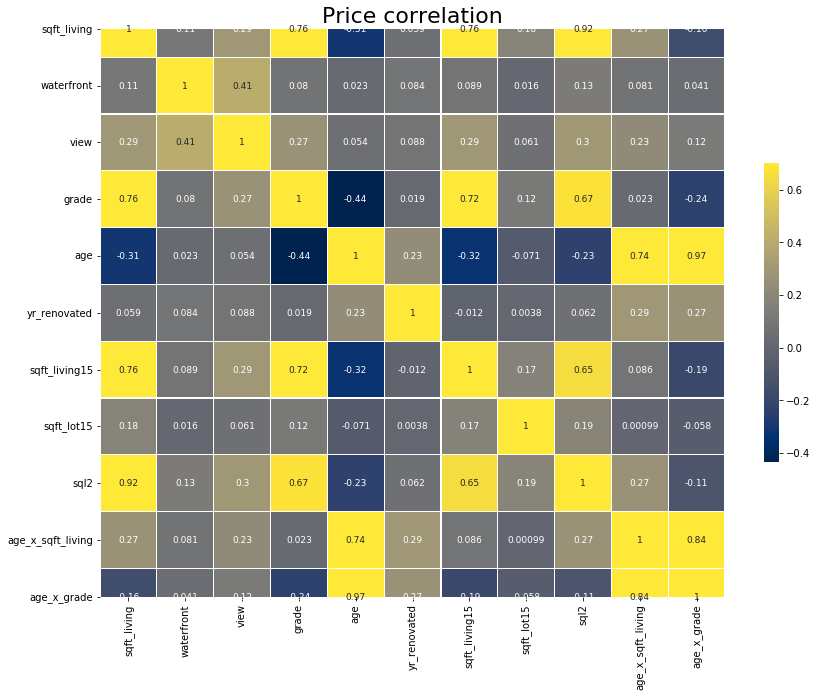

In [43]:
corr_matrix = df[features].corr()

corr_plot(corr_matrix, "Price correlation")

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

def rmse(y_test, y_pred):
    """root mean squared error"""
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)

def mae(y_test, y_pred):
    """mean average error"""
    return round(mean_absolute_error(y_test, y_pred), 3)

def mape(y_test, y_pred):
    """mean average percentage error"""
    return round(mean_absolute_percentage_error(y_test, y_pred), 3)

def wmape(y_test, y_pred):
    """weighted mean average percentage error"""
    wmape = sum(np.abs(y_test-y_pred)) / sum(np.abs(y_test))
    return round(wmape, 3)

In [15]:
# Let's use 70% of random sample to train the model, and the remaining 30% of sample to test how good is the model
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(f'Train set rows: {len(X_train)}')
print(f'Test set rows: {len(X_test)}')
lr = LinearRegression()
reg = lr.fit(X_train, y_train)
y_pred = np.exp(reg.predict(X_test))
y_test_exp = np.exp(y_test)
print()
print('******* Linear Model *******')
print()
print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')
print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')

Train set rows: 7564
Test set rows: 3242

******* Linear Model *******

Validation MAPE: 0.262
Validation WMAPE: 0.248
Validation MAE: 136094.828
Validation RMSE: 215684.365


In [16]:
# Permutation Feature Importance

import eli5
from eli5.sklearn import PermutationImportance

In [17]:
lr_perm = PermutationImportance(reg, random_state=42).fit(X_test, y_test)
eli5.show_weights(lr_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5158 ± 0.0235,grade
0.3474 ± 0.0168,sqft_living
0.1038 ± 0.0109,age
0.0483 ± 0.0062,sql2
0.0217 ± 0.0028,sqft_living15
0.0104 ± 0.0024,view
0.0093 ± 0.0035,age_x_sqft_living
0.0084 ± 0.0016,waterfront
0.0056 ± 0.0009,age_x_grade
0.0011 ± 0.0003,sqft_lot15


In [18]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [19]:
import graphviz

In [20]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=3, min_samples_split=5)
tree_model = dtr.fit(X_train, y_train)
y_pred = np.exp(tree_model.predict(X_test))
y_test_exp = np.exp(y_test)
print()
print('******* Decision Tree, max_depth=3 *******')
print()
print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')
print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')


******* Decision Tree, max_depth=3 *******

Validation MAPE: 0.296
Validation WMAPE: 0.285
Validation MAE: 156659.284
Validation RMSE: 281929.519


Let's vizualize the tree

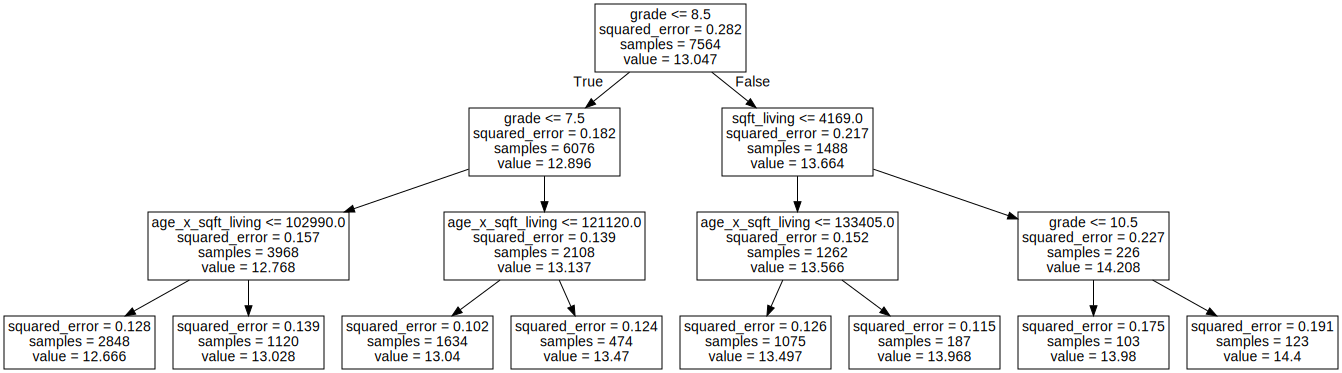

In [21]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)
graphviz.Source(tree_graph)

In [22]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=16, min_samples_split=10)
tree_model = dtr.fit(X_train, y_train)
y_pred = np.exp(tree_model.predict(X_test))
y_test_exp = np.exp(y_test)
print()
print('******* Decisiont Tree, max_depth=16 *******')
print()
print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')
print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')


******* Decisiont Tree, max_depth=16 *******

Validation MAPE: 0.288
Validation WMAPE: 0.278
Validation MAE: 152956.192
Validation RMSE: 273796.397


In [23]:
# tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)
# graphviz.Source(tree_graph)

In [24]:
perm = PermutationImportance(tree_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.4774 ± 0.0205,grade
0.3145 ± 0.0183,age_x_sqft_living
0.1961 ± 0.0065,sqft_living15
0.1342 ± 0.0201,sqft_lot15
0.0944 ± 0.0136,sql2
0.0926 ± 0.0071,age_x_grade
0.0703 ± 0.0095,sqft_living
0.0325 ± 0.0141,age
0.0144 ± 0.0039,view
0.0026 ± 0.0031,yr_renovated


In [25]:
# Partial Dependence Plots
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

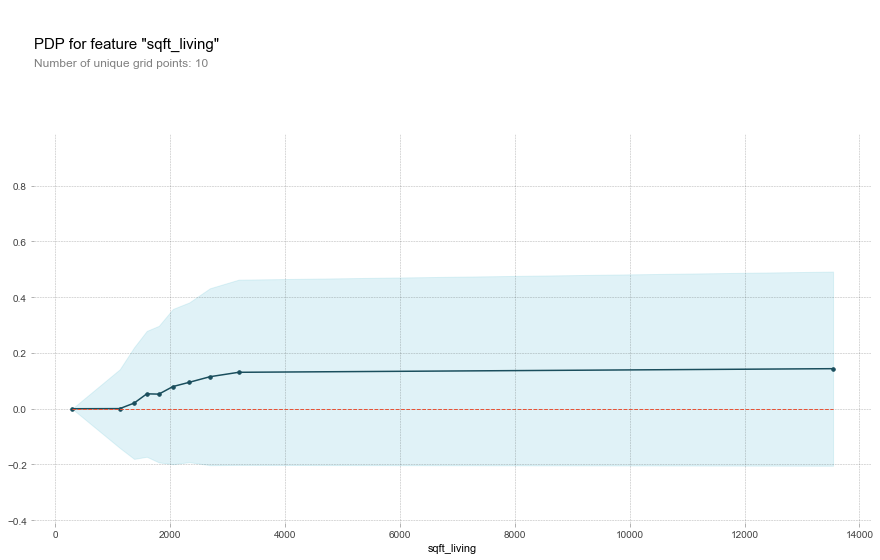

In [26]:
feature_to_plot = 'sqft_living'

pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=features, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

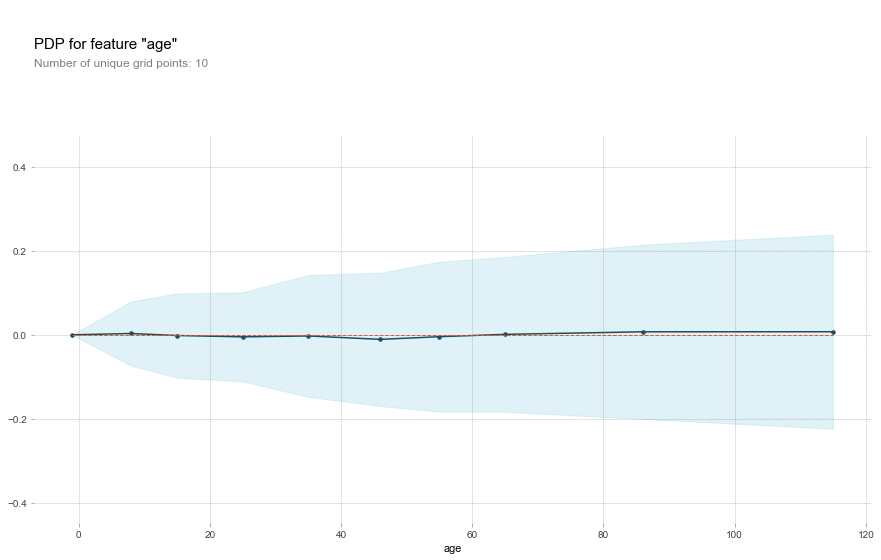

In [27]:
feature_to_plot = 'age'

pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=features, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

In [28]:
a = 1000
b = 1050

# let's estimate difference and percentage difference
print(f'b-a={b-a}')
print(f'(b-a)/a={(b-a)/a*100}%')
ln_a = np.log(a)
ln_b = np.log(b)
print(f'ln_b-ln_a={round((ln_b-ln_a)*100,1)}')

b-a=50
(b-a)/a=5.0%
ln_b-ln_a=4.9


## Explore SHAP package

- https://shap.readthedocs.io/en/latest/index.html
- https://www.kaggle.com/dansbecker/shap-values
- https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

## Investigate model prediction for a concrete case

### Tree model

In [39]:
import shap  # package used to calculate Shap values

row_to_show = 24

data_for_prediction = X_test.iloc[row_to_show] 
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
my_y_pred = tree_model.predict(data_for_prediction_array)[0]

print(f'Data: {data_for_prediction}')
print()
print('Decision Tree Model')
print()
print(f'Actual price: ${np.exp(y).iloc[row_to_show]:,.0f}')
print(f'Predicted price: ${np.exp(my_y_pred):,.0f}')

Data: sqft_living             1590
waterfront                 0
view                       0
grade                      7
age                       93
yr_renovated               0
sqft_living15           1570
sqft_lot15              4080
sql2                 2528100
age_x_sqft_living     147870
age_x_grade              651
Name: 14663, dtype: int64

Decision Tree Model

Actual price: $740,000
Predicted price: $563,302


In [40]:
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

shap_values = explainer.shap_values(data_for_prediction)

shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### Linear model

In [41]:
data_for_prediction = X_test.iloc[row_to_show] 
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
my_y_pred = lr.predict(data_for_prediction_array)[0]
print()
print('Linear Model')
print()
print(f'Actual price: ${np.exp(y).iloc[row_to_show]:,.0f}')
print(f'Predicted price: ${np.exp(my_y_pred):,.0f}')


Linear Model

Actual price: $740,000
Predicted price: $441,546


In [42]:
shap.initjs()

# Create object that can calculate shap values
explainer = shap.Explainer(lr, X_train, feature_names=features)

shap_values = explainer.shap_values(data_for_prediction)

shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

## Investigate model features across all validation dataset

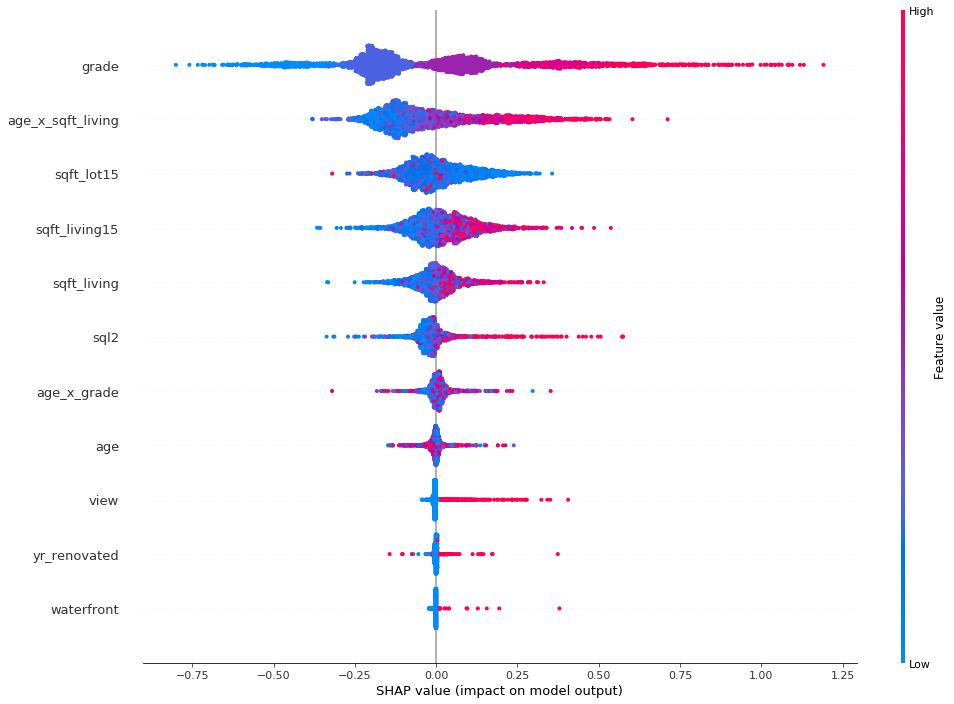

In [33]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate shap_values for all data points.
shap_values = explainer.shap_values(X_test)

# Make plot
shap.summary_plot(shap_values, X_test, plot_size=[16,12])

### Let's compare performance of a more complex model (ensample of trees):

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=16, min_samples_split=10).fit(X_train, y_train)

y_pred = np.exp(rf_model.predict(X_test))
y_test_exp = np.exp(y_test)
print()
print('******* Random Forest *******')
print()
print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')
print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')


******* Random Forest *******

Validation MAPE: 0.232
Validation WMAPE: 0.226
Validation MAE: 124434.299
Validation RMSE: 224306.329


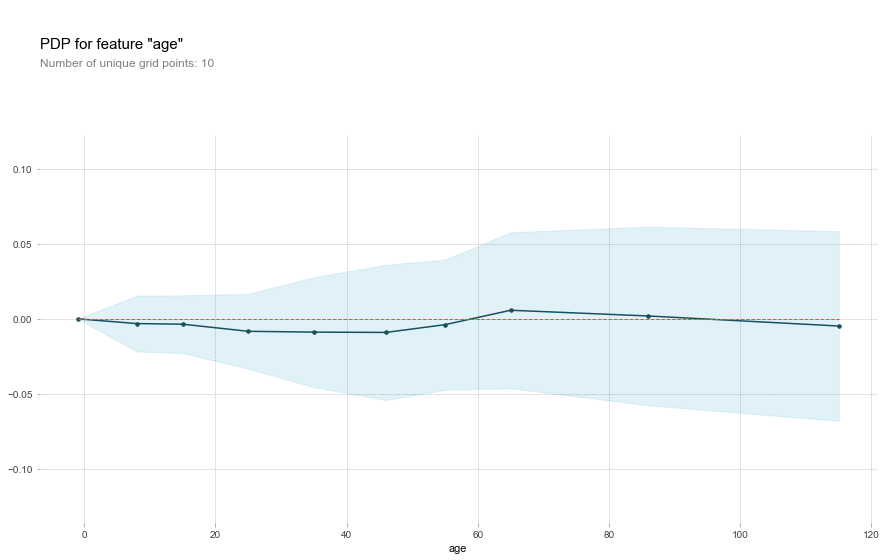

In [35]:
feature_to_plot = 'age'

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X_test, model_features=features, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

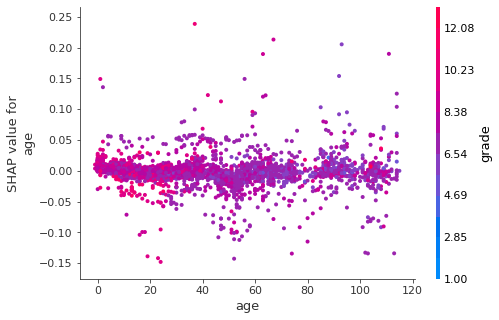

In [36]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate shap_values for all data points.
shap_values = explainer.shap_values(X_test)

# make plot.
shap.dependence_plot('age', shap_values, X_test, interaction_index="grade")

In [37]:
data_for_prediction = X_test.iloc[row_to_show] 
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
my_y_pred = rf_model.predict(data_for_prediction_array)[0]

print()
print('******* Random Forest *******')
print()
print(f'Actual price: ${np.exp(y).iloc[row_to_show]:,.0f}')
print(f'Predicted price: ${np.exp(my_y_pred):,.0f}')


******* Random Forest *******

Actual price: $450,000
Predicted price: $682,234


In [38]:
shap.initjs()

# Create object that can calculate shap values
explainer = shap.Explainer(rf_model, X_train, feature_names=features)

shap_values = explainer.shap_values(data_for_prediction)

shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)